## **Credit Card Fraud Detection using Scikit-Learn and Snap ML**


Building models to detect fraudulent credit card transaction using  Decision Tree and Support Vector Machine. 

Dataset: transactions made by credit cards in September 2013 by European cardholders


### Download Dataset from Kaggle

In [ ]:
# install the opendatasets package
!pip install opendatasets

import opendatasets as od

# download the dataset (this is a Kaggle dataset)
od.download("https://www.kaggle.com/mlg-ulb/creditcardfraud")

<div id="import_libraries">
    <h2>Import Libraries</h2>
</div>


In [ ]:
# Installing SnapML
!pip install snapml

In [3]:
# Import the libraries we need
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

### Dataset Exploration

In [4]:
# read the input data
raw_data = pd.read_csv('creditcardfraud/creditcard.csv')
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

# display the first rows in the dataset
raw_data.head()

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In practice, a financial institution may have access to a much larger dataset of transactions. To simulate such a case, we will inflate the original one 10 times.


In [5]:
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")

# display first rows in the new dataset
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


Each row in the dataset represents a credit card transaction. As shown above, each row has 31 variables. One variable (the last variable in the table above) is called Class and represents the target variable. For confidentiality reasons, the original names of most features are anonymized V1, V2 .. V28. The **values of these features are the result of a PCA transformation** and are numerical. The feature 'Class' is the target variable and it takes two values: 1 in case of fraud and 0 otherwise. For more information about the dataset please visit this webpage: https://www.kaggle.com/mlg-ulb/creditcardfraud.


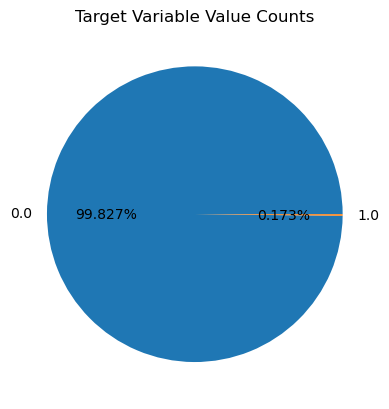

In [58]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

**Class** variable has two values: **0 (the credit card transaction is legitimate)** and **1 (the credit card transaction is fraudulent)**. Moreover, the dataset is **highly unbalanced**, the target variable classes are not represented equally. 


The credit card transactions have different amounts. We can visualize them with histogram.

In [59]:
print("Minimum amount value is ", np.min(big_raw_data.Amount.values))
print("Maximum amount value is ", np.max(big_raw_data.Amount.values))
print("75% of the transactions have an amount less or equal than ", np.percentile(raw_data.Amount.values, 75))
print("90% of the transactions have an amount less or equal than ", np.percentile(raw_data.Amount.values, 90))

Minimum amount value is  0.0
Maximum amount value is  25691.16
75% of the transactions have an amount less or equal than  77.16499999999999
90% of the transactions have an amount less or equal than  203.0


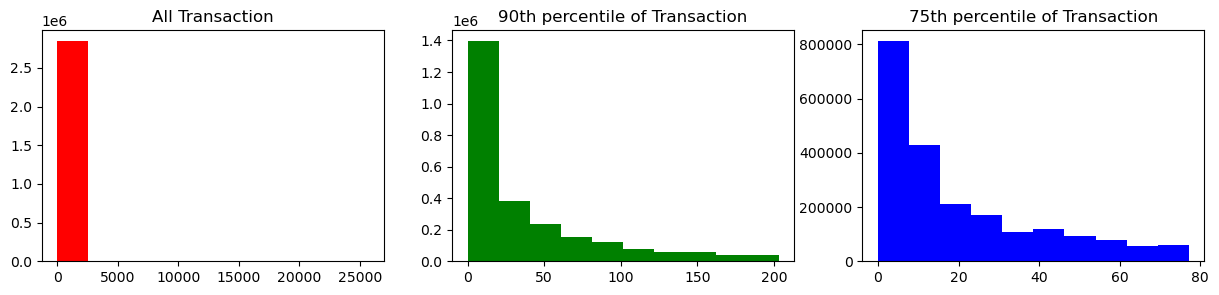

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
ax[0].hist(big_raw_data.Amount.values, range=(np.min(big_raw_data.Amount.values), np.max(big_raw_data.Amount.values)), facecolor='r')
ax[0].set_title('All Transaction')
ax[1].hist(big_raw_data.Amount.values, range=(np.min(big_raw_data.Amount.values), np.percentile(raw_data.Amount.values, 90)), facecolor='g')
ax[1].set_title('90th percentile of Transaction')
ax[2].hist(big_raw_data.Amount.values, range=(np.min(big_raw_data.Amount.values), np.percentile(raw_data.Amount.values, 75)), facecolor='b')
ax[2].set_title('75th percentile of Transaction')
plt.show()

### Dataset Preprocessing


In [40]:
big_raw_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [61]:
# standardize features by removing the mean and scaling to unit variance
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


### Build a Decision Tree Classifier model with Scikit-Learn


In [43]:
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from scikit-learn
from sklearn.tree import DecisionTreeClassifier

sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

# train a Decision Tree Classifier using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  49.68918


### Build a Decision Tree Classifier model with Snap ML


In [44]:
# import the Decision Tree Classifier Model from Snap ML
from snapml import DecisionTreeClassifier

# Snap ML offers multi-threaded CPU/GPU training of decision trees, 
# to set the number of CPU threads used at training time, set the n_jobs parameter
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)

# train a Decision Tree Classifier model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  10.39598


### Evaluate the Scikit-Learn and Snap ML Decision Tree Classifier Models


In [45]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# compute the probabilities of the test samples 
# to belong to the class of fraudulent transactions
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic 
# Curve (ROC-AUC) score from the predictions
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

# compute the probabilities of the test samples
# to belong to the class of fraudulent transactions
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic
# Curve (ROC-AUC) score from the prediction scores
snapml_roc_auc = roc_auc_score(y_test, snapml_pred)   
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : 4.78x 
[Scikit-Learn] ROC-AUC score : 0.966
[Snap ML] ROC-AUC score : 0.966


Both decision tree models provide the same score on the test dataset. However Snap ML runs the training routine almost 5x faster than Scikit-Learn. 


### Build a Support Vector Machine model with Scikit-Learn

In [47]:
# import the linear Support Vector Machine (SVM) model from Scikit-Learn
from sklearn.svm import LinearSVC

# set class_weight='balanced' to indicate the class imbalance at fit time
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

# train a linear Support Vector Machine model using Scikit-Learn
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  97.61


### Build a Support Vector Machine model with Snap ML


In [46]:
# import the Support Vector Machine model (SVM) from Snap ML
from snapml import SupportVectorMachine

snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)

# train an SVM model using Snap ML
t0 = time.time()
model = snapml_svm.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.2f}".format(snapml_time))

[Snap ML] Training time (s):  39.22


### Evaluate the Scikit-Learn and Snap ML Support Vector Machine Models


In [48]:
# compute the Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : {0:.2f}x '.format(training_speedup))

# run inference using the Scikit-Learn model
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)

# evaluate accuracy on test set
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn))

# run inference using the Snap ML model
# get the confidence scores for the test samples
snapml_pred = snapml_svm.decision_function(X_test)

# evaluate accuracy on test set
acc_snapml  = roc_auc_score(y_test, snapml_pred)
print("[Snap ML] ROC-AUC score:   {0:.3f}".format(acc_snapml))

[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : 2.49x 
[Scikit-Learn] ROC-AUC score:   0.984
[Snap ML] ROC-AUC score:   0.985


Both SVM models provide the same score on the test dataset. However, as in the case of decision trees, Snap ML runs the training routine faster than Scikit-Learn. 

### Evaluate SVM models quality using the hinge loss metric


In [49]:
# get the confidence scores for the test samples
# sklearn_pred = sklearn_svm.decision_function(X_test)
# snapml_pred  = snapml_svm.decision_function(X_test)

# import the hinge_loss metric from scikit-learn
from sklearn.metrics import hinge_loss

# evaluate the hinge loss from the predictions
loss_snapml = hinge_loss(y_test, snapml_pred)
print("[Snap ML] Hinge loss:   {0:.3f}".format(loss_snapml))

# evaluate the hinge loss metric from the predictions
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Hinge loss:   {0:.3f}".format(loss_snapml))

# the two models should give the same Hinge loss

[Snap ML] Hinge loss:   0.228
[Scikit-Learn] Hinge loss:   0.228
